In [2]:
#Load the Data
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.util import MLUtils
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import types
from pyspark.sql.functions import *
import re

#Read csv files into RDD
rdd1 = sc.textFile("Google.csv")
rdd2 = sc.textFile("Amazon.csv")

#Remove first header
googleHeader = rdd1.filter(lambda l: "id" in l)
googleHeader.collect()
googlerddNoHeader = rdd1.subtract(googleHeader)
googlerddNoHeader.take(2)

#Remove second header
AmazonHeader = rdd2.filter(lambda l: "id" in l)
AmazonHeader.collect()
AmazonrddNoHeader = rdd2.subtract(AmazonHeader)
AmazonrddNoHeader.take(2)

#Split the RDD file by comma
googlerdd = googlerddNoHeader.map(lambda line: line.split(","))
amazonrdd = AmazonrddNoHeader.map(lambda line: line.split(","))

In [3]:
#Create Dataframe from RDD and add column Names
Google_df = googlerdd.map(lambda line: Row(Id=line[0],
title=line[1],
description=line[2],
manufacture=line[3],
price=line[4])).toDF()

Amazon_df = amazonrdd.map(lambda line: Row(Id=line[0],
title=line[1],
description=line[2],
manufacture=line[3],
price=line[4])).toDF()

#Select only ID and description columns as per the requirement
google_df_select = Google_df.select('Id','description')
amazon_df_select = Amazon_df.select('Id','description')

In [4]:
#Create function to remove double quotes
import re
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

def remove_quotes(df):
    udf = UserDefinedFunction(lambda x: re.sub('"','',x), StringType())
    new_df = df.select(*[udf(column).alias(column) for column in df.columns])
    return new_df

In [5]:
#Remove double quotes using the above function
amazon_noquotes = remove_quotes(amazon_df_select)
google_noquotes = remove_quotes(google_df_select)

In [6]:
#Convert the dataframe to RDD
amazon_rdd_select = amazon_noquotes.rdd
google_rdd_select = google_noquotes.rdd

In [7]:
google_rdd_select.take(2)

[Row(Id='http://www.google.com/base/feeds/snippets/11343515411965421256', description='qb pos 6.0 basic retail mngmt software. for retailers who need basic inventory sales and customer tracking.'),
 Row(Id='http://www.google.com/base/feeds/snippets/13719401226624644329', description='adaptec 5325302018 : usually ships in 24 hours : : snap edr is a high-performance network-optimized software solution for distributing protecting and reporting on business-critical information throughout distributed enterprises.')]

In [8]:
#Part 2
#Read the stopwords file
stopwords = set(sc.textFile('C:/opt/spark/stopwords.txt').collect())
stopwords

{'!',
 '!!',
 '!?',
 '"',
 '#',
 '###',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'ll",
 "'m",
 "'s",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '-lrb-',
 '-lsb-',
 '-rrb-',
 '-rsb-',
 '.',
 '..',
 '...',
 ':',
 ';',
 '<',
 '>',
 '?',
 '?!',
 '??',
 '@',
 '[',
 ']',
 '^',
 '`',
 '``',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'arent',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'cant',
 'could',
 "couldn't",
 'couldnt',
 'did',
 "didn't",
 'didnt',
 'do',
 'does',
 "doesn't",
 'doesnt',
 'doing',
 "don't",
 'dont',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'hadnt',
 'has',
 "hasn't",
 'hasnt',
 'have',
 "haven't",
 'havent',
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'heres',
 'hers',
 'herself',
 'hes',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'hows',
 

In [9]:
#Create non-empty tokens by splitting using regular expressions
split_regex = r'\W+'
def simpleTokenise(string):
  return filter(None, re.split(split_regex, string))

In [10]:
#Implement a function, an improved tokenizer that does not emit stopwords.
def removeStopWords(listOfTokens):
  return [token for token in listOfTokens if token not in stopwords]

In [11]:
#Function to Remove Stopwords and tokenize the data
def tokeniseAndRemoveStopwords(string):
  List = simpleTokenise(string)
  return removeStopWords(List)

In [12]:
#Use the function created above to remove stopwords and tokenize description column
amazon_rdd = amazon_rdd_select.map(lambda s: (s[0], tokeniseAndRemoveStopwords(s[1])))
google_rdd = google_rdd_select.map(lambda s: (s[0], tokeniseAndRemoveStopwords(s[1])))

In [13]:
google_rdd.take(2)

[('http://www.google.com/base/feeds/snippets/11343515411965421256',
  ['qb',
   'pos',
   '6',
   '0',
   'basic',
   'retail',
   'mngmt',
   'software',
   'retailers',
   'need',
   'basic',
   'inventory',
   'sales',
   'customer',
   'tracking']),
 ('http://www.google.com/base/feeds/snippets/13719401226624644329',
  ['adaptec',
   '5325302018',
   'usually',
   'ships',
   '24',
   'hours',
   'snap',
   'edr',
   'high',
   'performance',
   'network',
   'optimized',
   'software',
   'solution',
   'distributing',
   'protecting',
   'reporting',
   'business',
   'critical',
   'information',
   'throughout',
   'distributed',
   'enterprises'])]

In [14]:
amazon_rdd.take(2)

[('b0006se5bq',
  ['singing',
   'coach',
   'unlimited',
   'electronic',
   'learning',
   'products',
   'win',
   'nt',
   '2000',
   'xp']),
 ('b000ehpzv8', ['emc', 'retrospect', '7', '5', 'disk', 'diskcromwindows'])]

In [15]:
# Function that takes a list of tokens and returns a dictionary mapping tokens to term frequency.
def termfreq(tokens):
    counts = {}
    for key in tokens:
      if key in counts:
        counts[key] += 1
      else:
        counts[key] = 1
    n_tokens = len(tokens)
    
    freq = {}
    for k,v in counts.items():
      freq[k] = 1.0*v/ n_tokens
    return freq

In [16]:
termfreq(amazon_rdd.filter(lambda x: x[0] == 'b0006se5bq').collect()[0][1])

{'2000': 0.1,
 'coach': 0.1,
 'electronic': 0.1,
 'learning': 0.1,
 'nt': 0.1,
 'products': 0.1,
 'singing': 0.1,
 'unlimited': 0.1,
 'win': 0.1,
 'xp': 0.1}

In [17]:
#Part 4
#Combine the amazon and google rdd with tokenized words
CorpusRDD = amazon_rdd.union(google_rdd)

In [340]:
#Convert the RDD to Dataframe to use with the HastingTF and IDF functions
CorpusDF = CorpusRDD.map(lambda line: Row(Id=line[0],
description=line[1])).toDF()
CorpusDF.take(2)

[Row(Id='b0006se5bq', description=['singing', 'coach', 'unlimited', 'electronic', 'learning', 'products', 'win', 'nt', '2000', 'xp']),
 Row(Id='b000ehpzv8', description=['emc', 'retrospect', '7', '5', 'disk', 'diskcromwindows'])]

In [280]:
#Part 3
#Use MLLIB to create IDF for the corpus
from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="description", outputCol="tf", numFeatures=4589)
featurizedData = hashingTF.transform(CorpusDF)

In [277]:
#Term frequency
featurizedData.take(2)

[Row(Id='b0006se5bq', description=['singing', 'coach', 'unlimited', 'electronic', 'learning', 'products', 'win', 'nt', '2000', 'xp'], tf=SparseVector(4589, {578: 1.0, 702: 1.0, 1894: 1.0, 1900: 1.0, 2663: 1.0, 2781: 1.0, 3320: 1.0, 3920: 1.0, 3928: 1.0, 4510: 1.0})),
 Row(Id='b000ehpzv8', description=['emc', 'retrospect', '7', '5', 'disk', 'diskcromwindows'], tf=SparseVector(4589, {534: 1.0, 1506: 1.0, 2240: 1.0, 2833: 1.0, 2867: 1.0, 4130: 1.0}))]

In [278]:
from pyspark.sql.functions import udf
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.linalg import SparseVector
from pyspark.ml.feature import HashingTF as MLHashingTF
from pyspark.ml.feature import IDF as MLIDF
from pyspark.sql.types import DoubleType

df = (CorpusDF.rdd.map(lambda x : (x[0],x[1])).toDF().withColumnRenamed("_1","Id").withColumnRenamed("_2","description"))

htf = MLHashingTF(inputCol="description", outputCol="tf")
tf = htf.transform(df)
tf.show()

+----------+--------------------+--------------------+
|        Id|         description|                  tf|
+----------+--------------------+--------------------+
|b0006se5bq|[singing, coach, ...|(262144,[47491,59...|
|b000ehpzv8|[emc, retrospect,...|(262144,[13087,63...|
|b0000dbykm|[mia, s, math, ad...|(262144,[19492,19...|
|b00006hmwc|[reference, domin...|(262144,[15013,17...|
|b000083k56|                  []|      (262144,[],[])|
|b000fm18vi|[chord, display, ...|(262144,[39221,80...|
|b0009rgzgm|[use, computer, r...|(262144,[15,13828...|
|b0000ycfdq|                  []|      (262144,[],[])|
|b0007g9760|[award, winning, ...|(262144,[5125,636...|
|b000ivhozk|[easy, fast, way,...|(262144,[3950,204...|
|b0009i9tqy|[build, skills, w...|(262144,[10462,30...|
|b0009stm6g|                  []|      (262144,[],[])|
|b000098xjo|                  []|      (262144,[],[])|
|b000ju9ndq|[diskeepeer, 2007...|(262144,[45283,61...|
|b000nqq29y|[monarch, v9, 0, 1u]|(262144,[8227,843...|
|b000h774k

In [282]:
#Part 5
#IDF, and TF-IDF calculations
idf = IDF(inputCol="tf", outputCol="idf")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

sum_ = udf(lambda v: float(v.values.sum()), DoubleType())
rescaledData.withColumn("idf_sum", sum_("idf")).show()

+----------+--------------------+--------------------+--------------------+------------------+
|        Id|         description|                  tf|                 idf|           idf_sum|
+----------+--------------------+--------------------+--------------------+------------------+
|b0006se5bq|[singing, coach, ...|(4589,[578,702,18...|(4589,[578,702,18...|40.727121209134054|
|b000ehpzv8|[emc, retrospect,...|(4589,[534,1506,2...|(4589,[534,1506,2...| 26.60508507448668|
|b0000dbykm|[mia, s, math, ad...|(4589,[681,724,12...|(4589,[681,724,12...| 57.07010641528898|
|b00006hmwc|[reference, domin...|(4589,[333,382,67...|(4589,[333,382,67...|134.25702459030916|
|b000083k56|                  []|        (4589,[],[])|        (4589,[],[])|               0.0|
|b000fm18vi|[chord, display, ...|(4589,[128,784,10...|(4589,[128,784,10...|53.436607152533945|
|b0009rgzgm|[use, computer, r...|(4589,[127,189,29...|(4589,[127,189,29...|242.48032367770162|
|b0000ycfdq|                  []|        (4589,[],

In [355]:
from operator import add
def idfs(corpus):
    uniqueTokens = corpus.flatMap(lambda pair: set(pair[1]))
    tokenCountPairTuple = uniqueTokens.map(lambda token: (token, 1.0))
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(add)
    N = corpus.count()
    return (tokenSumPairTuple.map(lambda pair: (pair[0], N/pair[1])))

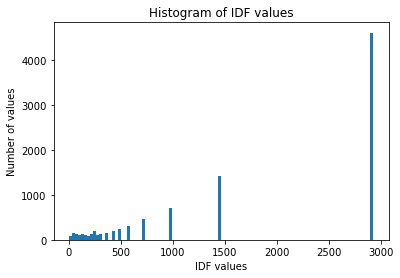

In [357]:
#Histogram of IDF values
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

idf_values = idfs(CorpusRDD).map(lambda pair: pair[1]).collect()
fig, ax = plt.subplots()
ax.hist(idf_values, 100)
plt.title("Histogram of IDF values")
plt.xlabel("IDF values")
plt.ylabel("Number of values")

In [467]:
#Part 6
#Calculate token frequencies for tokens
tokens = CorpusRDD.flatMap(lambda x: x[1])
tokenrdd = tokens.map(lambda line: line.split(","))
tokendf = tokenrdd.toDF().withColumnRenamed("_1","tokens")
book_tf = tokendf.groupBy("tokens").agg(func.count('*').alias('count')).orderBy('count', ascending=False)
book_tf.take(10)

[Row(tokens='software', count=1112),
 Row(tokens='s', count=548),
 Row(tokens='mac', count=453),
 Row(tokens='windows', count=431),
 Row(tokens='system', count=399),
 Row(tokens='new', count=353),
 Row(tokens='x', count=325),
 Row(tokens='1', count=310),
 Row(tokens='features', count=292),
 Row(tokens='hours', count=290)]

In [476]:
#Create a Python dictionary where each token maps to the token's frequency times the token's IDF weight
def tfidf(tokens,idfs):
    tfs = termfreq(tokens)
    tfIdfDict = dict((token, tfs[token]*idfs[token]) for token in tokens)
    return tfIdfDict

In [478]:
tokens_id = amazon_rdd.filter(lambda x: x[0] == 'b0006se5bq').collect()[0][1]
idf_wt = idfs(CorpusRDD).collectAsMap()
tfidf_id = tfidf(tokens_id, idf_wt)
tfidf_id

{'2000': 2.2538461538461543,
 'coach': 146.5,
 'electronic': 13.952380952380953,
 'learning': 3.530120481927711,
 'nt': 13.31818181818182,
 'products': 9.451612903225806,
 'singing': 48.833333333333336,
 'unlimited': 20.92857142857143,
 'win': 2.688073394495413,
 'xp': 1.754491017964072}